In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

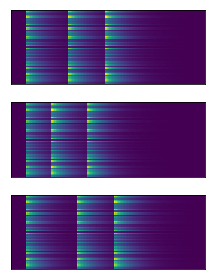

In [2]:
from twpca.datasets import jittered_population

data = jittered_population()[0]# + jittered_population()[0]

fig, axes = plt.subplots(3, 1)
for ax, trial in zip(axes, data):
    ax.imshow(trial.T)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

In [ ]:
from twpca import TWPCA

model = TWPCA(n_components=1)
model.fit(data)
aligned_data = model.transform(data)

 94%|█████████▍| 94/100 [00:12<00:00,  7.38it/s]

In [ ]:
from twpca.datasets import jittered_population

data = jittered_population()[0]# + jittered_population()[0]

fig, axes = plt.subplots(3, 1)
for ax, trial in zip(axes, aligned_data):
    ax.imshow(trial.T)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

In [ ]:
plt.plot(model.V[0])

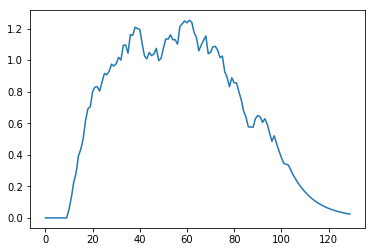

In [14]:
plt.plot(np.mean(model.V, axis=0))